# Week 1 Exercises: Neuron Models

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Helper functions

In [4]:
def PlotSpikeRaster(st, y_range=[0, 1.]):
    '''
    PlotSpikeRaster(spiketimes, y_range=[0, 1.])

    Plots a spike raster plot for a list of arrays of spike times.

    Input:
      spiketimes is a list of arrays of spike times, like that returned
          by the function Stim2Spikes.
      y_range is a 2-tuple that holds the y-values that the raster ticks
          should be drawn between
    '''
    N = len(st)  # number of neurons

    levels = np.linspace(y_range[1], y_range[0], N+1, endpoint=True)
    for n in range(N):
        nspikes = len(st[n])
        y = [ [levels[n+1]]*nspikes , [levels[n]]*nspikes ]
        plt.plot(np.vstack((st[n],st[n])), y, color=np.random.rand(3))
    plt.ylim(y_range)
    plt.xlabel('Time (s)')
    return


def GenerateSpikeTrain(rates, T, jitter=0.):
    '''
    spike_times = GenerateSpikeTrain(rates, T)
    
    Creates a spike train (as an array of time stamps).
    
    Input:
    rates is an array or list of firing rates (in Hz), one
        firing rate for each interval.
    T is an array or list (the same size as 'rates') that gives
        the ending time for each interval
    jitter is a scalar that determines how much the spikes
        are randomly moved
        
    Output:
    spike_times is an array of times when spikes occurred
    
    Example: To create a spike train of 10Hz for 0.5s, followed
             by 25Hz that starts at 0.5s and ends at 2s, use
             
               GenerateSpikeTrain([10, 25], [0.5, 2])
    '''
    s = []
    t = 0.
    for idx in range(0,len(rates)):
        Trange = T[idx] - t
        if rates[idx]!=0:
            delta = 1. / rates[idx]
            N = rates[idx] * Trange
            times = np.arange(t+delta/2., T[idx], delta)
            times += np.random.normal(scale=delta*jitter, size=np.shape(times))
            s.extend(times)
        t = T[idx]
    s.sort()
    return np.array(s)


def spikes_between(spiketrain, t_start, t_end):
    '''
     numspikes = spikes_between(spiketrain, t_start, t_end)

     Returns the number of times between t_start and t_end.
     Specifically, it counts a spike if it occurred at t, where
     t_start <= t < t_end
    
     Inputs:
       spiketrain   array-like list of spike times
       t_start      start time
       t_end        end time
       
     Output:
       numspikes    number of spikes, where t_start <= t < t_end
    '''
    sp_bool = np.logical_and( np.array(spiketrain)>=t_start, np.array(spiketrain)<t_end )
    return np.sum(sp_bool)

# Classes

## `Neuron` class
This is the base class for different types of neurons.

In [5]:
class Neuron(object):
    def __init__(self):
        self.t = 0.       # current time
        self.axon = []    # list of outgoing connections
        
    def slope(self):
        return 0.
        
    def step(self, dt):
        raise NotImplementedError
        
    def send_spike(self, n=1):
        for a in self.axon:
            a.transmit(n)

## `Synapse` class
This class represents a connection between two neurons.

In [6]:
class Synapse(object):
    '''
     The Synapse class represents a connection between a pre-synaptic neuron and
     post-synaptic neuron. This class implements the presence and strength (weight)
     of the connection, but does NOT model the dynamics of the connection.
    '''
    def __init__(self, pre, post, w):
        self.pre = pre               # pre-synaptic neuron (object)
        self.post = post             # post-synaptic neuron (object)
        self.pre.axon.append(self)   # record this synapse in the pre-syn neuron
        self.w = w                   # connection weight
        
    def transmit(self, n=1):
        '''
         syn.transmit(n=1)
         
         Transmit n spikes through this synapse, from the
         pre-syn neuron to the post-syn neuron. The spikes get multiplied
         by this Snyapse's connection weight.
        '''
        self.post.receive_current(n*self.w)

## `InputNeuron` class
Derived from the `Neuron` class, this class is for generating input to feed into a network.

In [7]:
class InputNeuron(Neuron):
    
    def __init__(self, spiketrain):
        '''
         InputNeuron(spiketrain)
        
         Constructor for InputNeuron class.
        
         InputNeuron is a class of neuron that can be used to inject spikes into
         the network. When involved in a simulation, an InputNeuron will generate
         spikes at the times specified during its construction.
        
         Inputs:
           spiketrain is an array or list of spike times
        '''
        super().__init__()
        self.spikes = np.array(spiketrain)

    def step(self, slopes, dt):
        n_spikes = spikes_between(self.spikes, self.t, self.t+dt)
        self.t += dt
        if n_spikes>0:
            self.send_spike(n_spikes)

## `LIFNeuron` class
Derived from the `Neuron` class, this class implements the Leaky Integrate-and-Fire (LIF) neuron.

<div class="alert alert-block alert-info">
<b>Exercise 3</b><br>
    Complete the method <code>slope</code>, according to is documentation string.</div>

In [8]:
class LIFNeuron(Neuron):

    def __init__(self, Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05):
        '''
         LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)
        
         Constructor for LIFNeuron class
        
         Inputs:
           Tau_m   membrane time constant, in seconds (s)
           Tau_ref refractory period (s)
           Tau_s   synaptic time constant (s)
        '''
        super().__init__()
        # self.t and self.axon are defined in the super-class, Neuron.
        self.tau_m = Tau_m      # membrane time constant
        self.tau_ref = Tau_ref  # refractory period
        self.tau_s = Tau_s      # synaptic time constant
        self.v = 0.             # sub-threshold membrane potential (voltage)
        self.s = 0.             # post-synaptic current (PSC)
        
        self.weighted_incoming_spikes = 0.  # weighted sum of incoming spikes (for one time step)
        self.ref_remaining = 0. # amount of time remaining in the refractory period
        
        # For plotting
        self.v_history = []     # records v over time
        self.s_history = []
        self.spikes = []        # list of times when this neuron spiked
    
    def slope(self):
        '''
         LIFNeuron.slope()
        
         Evaluates the right-hand side of the differential equations that
         govern v and s.
         
         Output
          [dvdt, dsdt]  the slopes, in a list
        '''
        
        #=================================================
        #=================================================
        # EXERCISE
        # Set the return variables dvdt and dsdt so that
        # they are the RHS of the DEs that govern v
        # and s (voltage and input current).
        #=================================================
        #=================================================

        dvdt = (self.s - self.v) / self.tau_m
        dsdt = (- self.s) / self.tau_s
                
        return [dvdt, dsdt]
        
        
    def step(self, slopes, dt):
        '''
         LIFNeuron.step(dt)
        
         Updates the LIF neuron state by taking an Euler step in v and s.
         The length of the step is dt seconds.
         
         Input
          slopes   list-like, containing the slopes of v and s
          dt       time step (in seconds)
          
         If v reaches the threshold of 1, the neuron fires an action potential
         (spike). Linear interpolation is used to estimate the time that v=1.
         The spike time is appended to the list self.spikes, and v
         is set to zero. After a spike, the neuron is dormant for self.tau_ref
         seconds.
        '''
        dvdt, dsdt = slopes
        # Update input current, included newly-arrived spikes
        self.s += dt*dsdt + self.weighted_incoming_spikes/self.tau_s
        
        v_previous = self.v
        t = self.t
        dt_integrate = dt
        
        # Implement refractory period
        if dt-self.ref_remaining>0:
            dt_integrate = max(0, dt-self.ref_remaining)
            t = self.t + self.ref_remaining
            self.v += dt_integrate*dvdt  # Euler step
            self.ref_remaining = 0
        else:
            self.v = 0.
            self.ref_remaining -= dt
        
        # Detect spike: if v reaches 1, spike
        if self.v>=1.0:
            # SPIKE!

            # Interpolate spike time
            v0 = v_previous
            v1 = self.v
            tstar = t + dt_integrate * (1.-v0) / (v1-v0)
            self.spikes.append(tstar)  # Record spike time

            self.v = 1.  # Set v to 1 (or zero)

            self.ref_remaining = self.tau_ref - (dt - (tstar-self.t))
            
            # Broadcast the spike to downstream neurons
            self.send_spike()

        # Store v (for plotting), and reset incoming spike accumulator
        self.v_history.append(self.v)
        self.s_history.append(self.s)
        self.weighted_incoming_spikes = 0.
        self.t += dt
        
    def receive_current(self, c):
        '''
         LIFNeuron.receive_current(c)
        
         Registers the arrival of current from a synapse. The
         member variable self.total_injected_current keeps track of all
         the incoming current for a time step.
        
         It is sufficient to add all currents together to tabulate the
         total incoming current (from all presynaptic neurons).
        
         Input:
           c    incoming current
        '''
        self.weighted_incoming_spikes += c
        
        
    def __repr__(self):
        '''
         print(neur)
         
         Prints the current time, membrane potential, input current, and
         remaining refractory time.
        '''
        return '{0:6.4f}s: s={1:5.3f}, v={2:6.4f}, ref remaining={3:7.5f}'.format(self.t, self.s, self.v, self.ref_remaining)


## `SpikingNetwork` class
This class represents a collection of neurons and their connections to each other. Add neurons, connect them, and then simulate the network.

In [9]:
class SpikingNetwork(object):
    '''
     SpikingNetwork()

     Constructor for SpikingNetwork class.

     The SpikingNetwork class contains a collection of neurons,
     and the connections between those neurons.
    '''
    def __init__(self):
        self.neur = []         # List of neurons (of various kinds)
        self.conn = []         # List of connections
        self.t_history = []    # List of time stamps for the Euler steps
                               # (Useful for plotting)
            
    def add_neuron(self, neur):
        '''
         SpikingNetwork.add_neuron(neuron)
        
         Adds a neuron to the network.
        
         Input:
           neuron is an object of type LIFNeuron or InputNeuron
        '''
        self.neur.append(neur)
        
    def connect(self, pre, post, w):
        '''
         SpikingNetwork.connect(pre, post, w)
        
         Connects neuron 'pre' to neuron 'post' with a connection
         weigth of w.
        
         where
          pre    is the pre-synaptic neuron object,
          post   is the post-synaptic neuron object, and
          weight is the connection weight.
        '''
        syn = Synapse(pre, post, w)
        self.conn.append(syn)
        
    def simulate(self, T, dt):
        '''
         SpikingNetwork.simulate(T, dt)
        
         Simulates the network for T seconds by taking Euler steps
         of size dt.
        
         Inputs:
           T    how long to integrate for
           dt   time step for Euler's method
        '''
        
        current = 0 if len(self.t_history)==0 else self.t_history[-1]
        t_segment = np.arange(current, current+T, dt)
        
        for tt in t_segment:
            self.t_history.append(tt)
            
            # Compute slopes for all neurons first...
            slopes = []
            for neur in self.neur:
                slopes.append(neur.slope())
                
            # ... then update the neurons using an Euler step.
            for neur,slope in zip(self.neur, slopes):
                neur.step(slope, dt)
                    
    def all_spike_times(self):
        '''
         SpikingNetwork.AllSpikeTimes()
        
         Returns all the spikes of all the neurons in the network.
         Useful for making spike-raster plots of network activity.
        
         Output:
           all_spikes  a list of sublists, where each sublist holds
                       the spike times of one of the neurons
        '''
        all_spikes = []
        for neur in self.neur:
            all_spikes.append(np.array(neur.spikes))
        return all_spikes

# Exercises

## A single LIF neuron

In [10]:
# Let's create a LIF neuron
lif_a = LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)

# Set its state so it's just about to spike
lif_a.t = 0.3
lif_a.v = 0.98  # lif.v is just below 1.0
lif_a.s = 1.3   # this strong input current should push it over the threshold

# Now let's take a few time steps
dt = 0.001  # 1 ms
print(lif_a)
for n in range(4):
    system_slopes = lif_a.slope()
    lif_a.step(system_slopes, dt)
    print(lif_a)

if len(lif_a.spikes)>0:
    print('Spike occurred at {0:.5g} seconds'.format(lif_a.spikes[-1]))

0.3000s: s=1.300, v=0.9800, ref remaining=0.00000
0.3010s: s=1.274, v=0.9960, ref remaining=0.00000
0.3020s: s=1.249, v=1.0000, ref remaining=0.00129
0.3030s: s=1.224, v=0.0000, ref remaining=0.00029
0.3040s: s=1.199, v=0.0436, ref remaining=0.00000
Spike occurred at 0.30129 seconds


Output should be
```
0.3000s: s=1.300, v=0.9800, ref remaining=0.00000
0.3010s: s=1.274, v=0.9960, ref remaining=0.00000
0.3020s: s=1.249, v=1.0000, ref remaining=0.00129
0.3030s: s=1.224, v=0.0000, ref remaining=0.00029
0.3040s: s=1.199, v=0.0436, ref remaining=0.00000
Spike occurred at 0.30129 seconds
```

## LIF neuron driven by an input neuron

In [16]:
# This will create a small network to play with.
net = SpikingNetwork()
A = LIFNeuron(Tau_s=0.1)  # Create a LIF neuron

# Create an input neuron (20Hz for 1s, then 15Hz for 0.5s)
in1 = InputNeuron( GenerateSpikeTrain([20, 15], [1, 1.5]) )

net.add_neuron(A)    # Add LIF neuron A
net.add_neuron(in1)  # Add input neuron
net.connect(in1, A, 0.05)  # Connection from neuron A to neuron in1

net.simulate(1.5, 0.001) # Simulate for 1 second

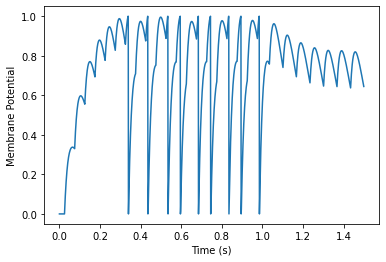

In [17]:
# Plot the membrane potential of net.neuron[0]
# time is in net.t_history
# membrane potential (v) is in net.neur[0].v_history
plt.plot(net.t_history, net.neur[0].v_history);
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential');

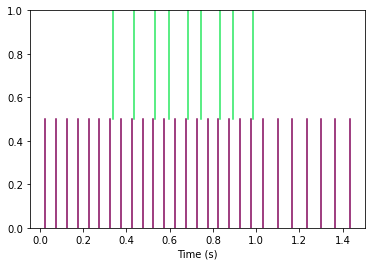

In [18]:
# Plot the spike rasters for all the neurons in the network.
# You can get all the spikes from net.all_spike_times()
PlotSpikeRaster( net.all_spike_times() )

## LIF Tuning Curve
Let's run a LIF neuron for a bunch of different input currents to see how its firing rate changes.

In [11]:
# i.
# Create network
net = SpikingNetwork()

# LIF neuron
A = LIFNeuron(Tau_s=0.1)
net.add_neuron(A)  # add it to the network

# Input neuron
ti = np.arange(1, 21)*2.  # Set up time in 2-second increments [2 4 6... 42]
in_fr = np.arange(1, 21)*5.  # Corresponding firing rates [5 10, 15... 105]
in1 = InputNeuron( GenerateSpikeTrain(in_fr, ti) )
net.add_neuron(in1)  # add it to the network

# Connect and simulate
# connect in1 to A with weight 0.03
net.connect(in1, A, 0.03)
# Simulate for 42 seconds using a time-step of 1 ms
net.simulate(ti[-1], 0.001)

In [12]:
# ii.
# Loop through the spikes and separate them into 2-second intervals,
# and compute the average firing rate during each interval.
out_fr = []
# Loop over intervals
for idx in range(len(ti)):
    # Get firing rate for each 2s interval
    tstart = 0 if idx==0 else ti[idx-1]
    out_fr.append( spikes_between(net.neur[0].spikes, tstart, ti[idx])/2. )

<div class="alert alert-block alert-info">
    Does the firing-rate curve below have the same shape as the tuning curve plotted in the lectures?</div>

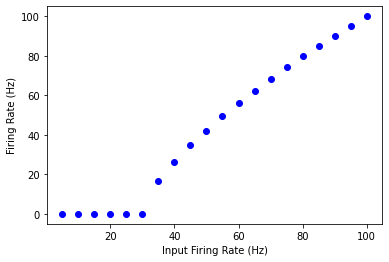

In [13]:
# iii.
# Plot, with appropriate axis labels
plt.plot(in_fr, out_fr, 'bo')
plt.xlabel('Input Firing Rate (Hz)')
plt.ylabel('Firing Rate (Hz)');